In [1]:
# Import the necessary libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, Dense, Lambda, LSTM, RepeatVector, TimeDistributed, Flatten, Reshape
from keras.models import Model
from keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from keras.losses import binary_crossentropy
from keras import backend as K
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Load the original dataset
processed_data = pd.read_csv('Processed Data/Aruba_17/processed_data.csv')
# Find the maximum number that can be evenly divisible by 32, given the length of the dataset
max_length = len(processed_data) - len(processed_data) % 32
processed_data = processed_data.head(6400)

# Extract the relevant columns from the dataset
timestamp = processed_data['Timestamp'].values
device_id = processed_data['Device ID'].values
status = processed_data['Status'].values
activity = processed_data['Activity'].values
activity_status = processed_data['Activity Status'].values

In [ ]:
# X = np.stack((timestamp, device_id, status, activity, activity_status), axis=1)

# # Normalize the data using z-score normalization
# scaler = StandardScaler()
# X = scaler.fit_transform(X)

# # Scale the values to be within the range of 0 to 1
# min_max_scaler = MinMaxScaler()
# X = min_max_scaler.fit_transform(X)

In [2]:
# Define the log directory for TensorBoard
# log_dir = "logs/"

# Create a callback for TensorBoard
# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# Prepare the data for input into the VAE model
X = np.stack((timestamp, device_id, status, activity, activity_status), axis=1)

# Normalize the data using minMaxScaler
scaler = MinMaxScaler()
X = scaler.fit_transform(X)
# print(X.head(20))

# Use KMeans to cluster sequences into 14 different groups
kmeans = KMeans(n_clusters=14, random_state=0)
clusters = kmeans.fit_predict(X)

# Split the data into training and testing sets
batch_size = 32
validation_split = 0.2
timesteps = 128 # number of previous records considered
input_dim = X.shape[1] # number of features, there are 5 features in the dataset

# Split the data into training and testing sets
X_train, X_val, y_train, y_val = train_test_split(X, clusters, test_size=validation_split, shuffle=False)

# Pad the data to ensure it is divisible by the desired shape
remainder_train = X_train.shape[0] % (batch_size * timesteps)
if remainder_train > 0:
    X_train = np.concatenate([X_train, np.zeros((batch_size * timesteps - remainder_train, input_dim))])
    y_train = np.concatenate([y_train, np.zeros((batch_size * timesteps - remainder_train,))])
    
remainder_val = X_val.shape[0] % (batch_size * timesteps)
if remainder_val > 0:
    X_val = np.concatenate([X_val, np.zeros((batch_size * timesteps - remainder_val, input_dim))])
    y_val = np.concatenate([y_val, np.zeros((batch_size * timesteps - remainder_val,))])

# Reshape the datasets to have the correct shape for the model
X_train = X_train.reshape((-1, timesteps, input_dim))
y_train = y_train.reshape((-1, timesteps))

X_val = X_val.reshape((-1, timesteps, input_dim))
y_val = y_val.reshape((-1, timesteps))

latent_dim = 2
encoding_dim = 32

# ==================== ENCODER ====================
inputs = Input(batch_shape=(batch_size, timesteps, input_dim), name='encoder_input')
x = LSTM(encoding_dim*2, return_sequences=True)(inputs)
x = LSTM(encoding_dim, return_sequences=False)(x) 
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)
# z_mean is the mean of the latent space
# z_log_var is the variance of the latent space

def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
# encoder.summary()

# ================= LATENT SPACE ==================
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
# ==================== DECODER ====================
x = Dense(timesteps * encoding_dim, activation='relu')(latent_inputs)
x = Reshape((timesteps, encoding_dim))(x)
x = LSTM(encoding_dim, return_sequences=True, input_shape=(timesteps, encoding_dim))(x)
x = TimeDistributed(Dense(input_dim))(x)
# LSTM layer in the decoder is used to reconstruct the original sequence

# the VAE model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
decoder = Model(latent_inputs, x, name='decoder')
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae')

# Loss function
# reconstruction_loss = K.mean(binary_crossentropy(K.flatten(inputs), K.flatten(outputs)))
# reconstruction_loss *= timesteps * input_dim
# kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
# kl_loss = K.mean(kl_loss, axis=-1)
# kl_loss *= -0.5
# # vae_loss = reconstruction_loss + kl_loss
# vae_loss = reconstruction_loss + kl_loss
# vae.add_loss(vae_loss)
# vae.compile(optimizer='adam')
reconstruction_loss = binary_crossentropy(K.flatten(inputs), K.flatten(outputs))
# reconstruction_loss = K.mean(reconstruction_loss)
reconstruction_loss *= timesteps * input_dim
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
# kl_loss = K.mean(kl_loss, axis=-1)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
# vae_loss = reconstruction_loss + kl_loss
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
# vae.summary()
# callbacks=[tensorboard_callback]
num_epochs = 300
history = vae.fit(X_train, epochs=num_epochs, batch_size=batch_size, validation_data=(X_val, y_val))

# plot_model(vae, to_file='model.png', show_shapes=True)
# Use the encoder to generate embeddings for each sequence
encoder_model = Model(inputs, z_mean)
# print(encoder_model.layers[0].input_shape)

X_embedded = encoder_model.predict(X_train, batch_size=batch_size)
# Potentially change from the encoder_model to the vae_model, it will be slower but will be more expressive and representative of the data.

# Train a classifier on the embeddings
y_pred = kmeans.fit_predict(X_embedded)

Epoch 1/300
2/2 [==============================] - 9s 2s/step - loss: 2726.1409 - val_loss: 1210.1655
Epoch 2/300
2/2 [==============================] - 0s 141ms/step - loss: 1685.4363 - val_loss: 1090.5575
Epoch 3/300
2/2 [==============================] - 0s 139ms/step - loss: 1486.0469 - val_loss: 1038.2996
Epoch 4/300
2/2 [==============================] - 0s 131ms/step - loss: 1399.1285 - val_loss: 1005.3638
Epoch 5/300
2/2 [==============================] - 0s 130ms/step - loss: 1324.5244 - val_loss: 969.8781
Epoch 6/300
2/2 [==============================] - 0s 129ms/step - loss: 1245.3683 - val_loss: 923.6373
Epoch 7/300
2/2 [==============================] - 0s 131ms/step - loss: 1181.1282 - val_loss: 912.9176
Epoch 8/300
2/2 [==============================] - 0s 128ms/step - loss: 1117.2798 - val_loss: 864.8527
Epoch 9/300
2/2 [==============================] - 0s 132ms/step - loss: 1051.2363 - val_loss: 840.8665
Epoch 10/300
2/2 [==============================] - 0s 128ms/st

In [3]:
# Generate a fake dataset using the VAE model
n_samples = len(processed_data)

noise = np.random.normal(size=(n_samples, timesteps, input_dim))
predicted_values = vae.predict(noise, batch_size=batch_size)
# reshape predicted values to have the correct shape
predicted_values = np.reshape(predicted_values, (n_samples, timesteps, input_dim))

# undo the normalization
predicted_values = np.reshape(predicted_values, (-1, input_dim))
# predicted_values = min_max_scaler.inverse_transform(predicted_values)
predicted_values = scaler.inverse_transform(predicted_values)
# Round each of the values in the array to the nearest integer
predicted_values = np.rint(predicted_values)

# Save the prediction data to a new file 'predicted_Data.csv'
predicted_data = pd.DataFrame(predicted_values.reshape((-1, input_dim)), columns=['Timestamp', 'Device ID', 'Status', 'Activity', 'Activity Status'])
# predicted_data['Cluster'] = y_pred.reshape(-1)
# predicted_data.to_csv('Predictions/Aruba_17_prediction.csv', index=False)
with open('Predictions/Aruba_17_prediction.txt', 'w') as file:
    for _, row in predicted_data.iterrows():
        file.write(','.join(map(str, row.values)) + '\n')

200/200 [==============================] - 8s 30ms/step


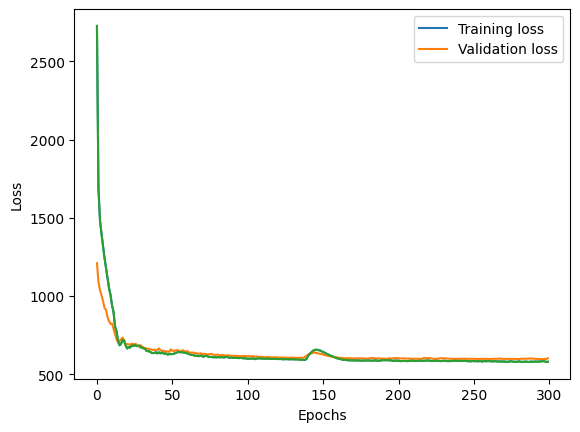

In [4]:
# Plot the training and validation loss with x and y labels, and a grid
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.legend()
# Validation loss > training loss, underfitting
# validation loss > training loss, overfitting, if it decreases and then increases again.
# If they both decreease and stabilize at a specific point, it is an optimal fit.

# Plot the evaluation loss vs the iterations
plt.plot(history.history['loss'], label='Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()


In [ ]:
# # Plot the model
# from keras.utils import plot_model

# # Display the layers, number of layers, number of nodes etc
# plot_model(vae, to_file='vae.png', show_shapes=True, show_layer_names=True)

# # Load the image and display it
# img = plt.imread('vae.png')
# plt.figure(figsize=(16, 12))
# plt.imshow(img)
# plt.axis('off')
# plt.show()
